# Clean submission using mask PCA

In [53]:
import utils
import cv2
import glob
import os
import sys
import pylab as pl
import skimage
import matplotlib.cm as cm

%load_ext Cython

%matplotlib inline

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [54]:
SUBNAME = '../submissions/submission42.csv'

# Load submissions masks

In [55]:
%%cython
#%%cython --annotate
from cython cimport view

cimport cython
cimport numpy as np
cimport openmp
import numpy as np

@cython.boundscheck(False)
@cython.cdivision(True)
def runlen_decode(line, shape):
    img = np.zeros(shape, order='C', dtype=np.uint8)
    cdef np.uint8_t[::1] c_img = img.reshape(-1, order='C')
    cdef int start
    cdef int length
    cdef int i
    cdef int j
    cdef int pix
    
    runs = line.split(',')[1].strip().split(' ')
    if len(runs) > 1: # runs will be [''] for an empty image
        runs = [int(v) for v in runs]
        runs = zip(*(runs[0::2], runs[1::2]))
        
        for start, length in runs:
            for pix in range(start, start + length):
                c_img[pix] = 255
     
    return np.asarray(img, order='C').transpose()

@cython.boundscheck(False)
def runlen_encode(img):
    cdef np.uint8_t[::1] c_img = img.reshape(img.shape[0] * img.shape[1], order='F')
    runs = []
    cdef int npixels = len(c_img)
    cdef np.uint8_t c
    
    cdef int run_start = 1
    cdef int run_length = 0
    for i in range(npixels):
        c = c_img[i]
        if c == 0:
            if run_length != 0:
                # for kaggle, pixels are numbered from 1, hence the + 1
                runs.append((run_start + 1, run_length))
                run_length = 0
        else:
            if run_length == 0:
                run_start = i
            run_length += 1
    
    if run_length != 0:
        # for kaggle, pixels are numbered from 1, hence the + 1
        runs.append((run_start + 1, run_length))
    return runs

In [56]:
masks = []
nlines = 5508
with open(SUBNAME) as f:
    f.readline()
    for i, line in enumerate(f):
        if i % 10 == 0:
            print '\r%d / %d' % (i, nlines),
            sys.stdout.flush()
        masks.append(runlen_decode(line, (580, 420)))
        
masks = np.array(masks)

5500 / 5508


# Learn mask PCA on training set

In [57]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X = _d['X'][:,None,:,:]
Y = _d['Y'][:,None,:,:]

In [58]:
from sklearn.decomposition import TruncatedSVD
pca2 = TruncatedSVD(n_components=20).fit(Y.reshape(-1, 128*128))

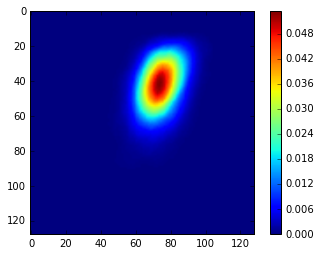

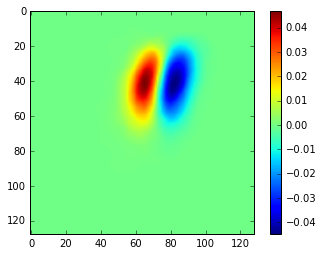

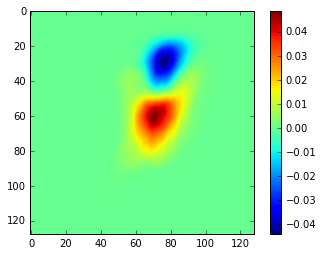

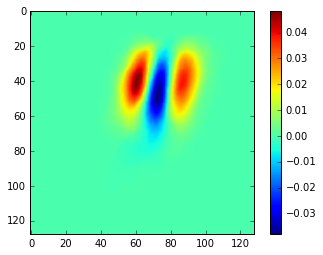

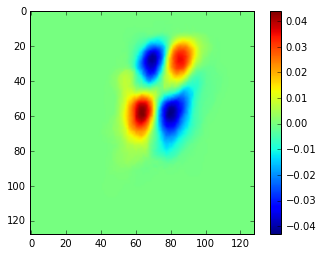

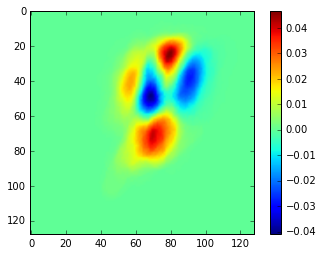

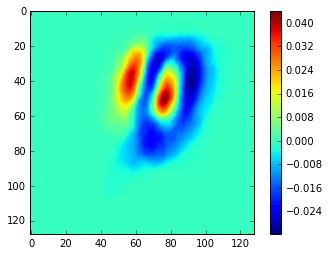

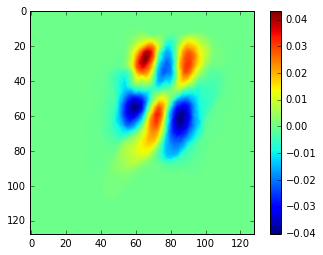

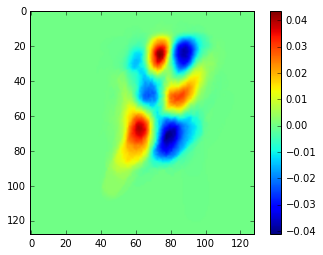

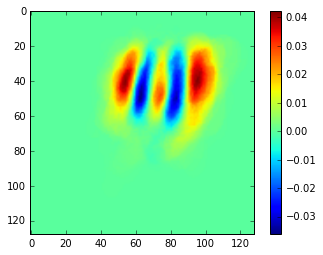

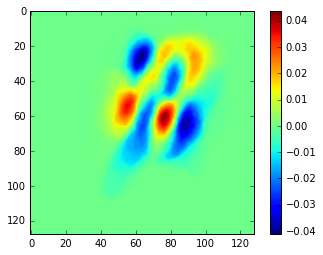

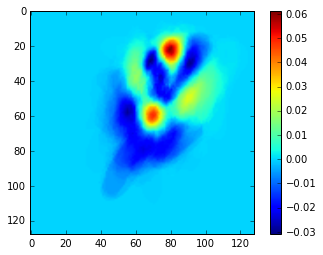

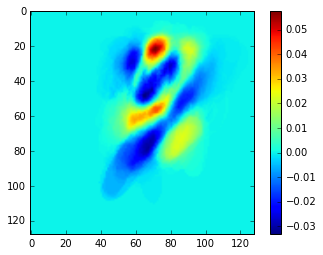

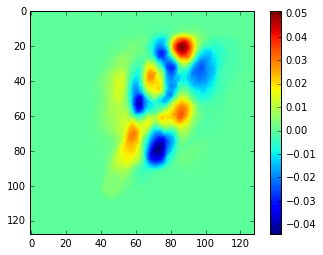

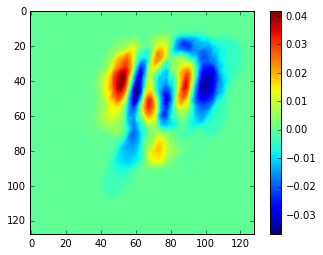

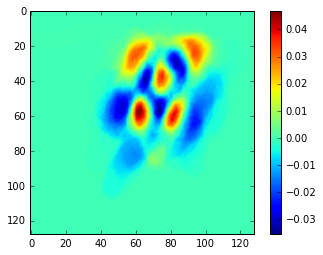

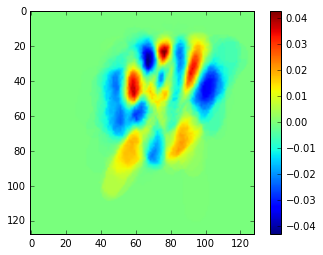

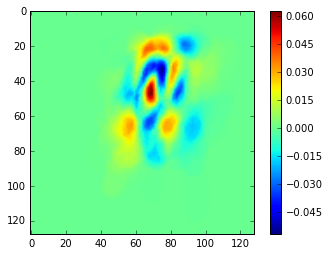

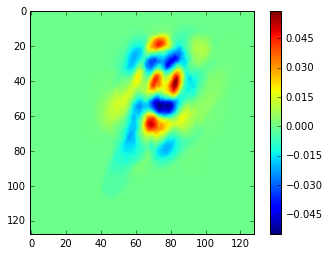

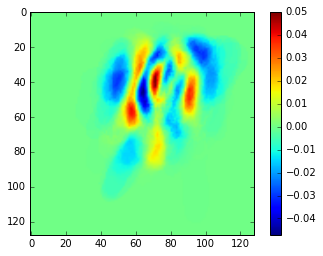

In [59]:
for i in range(pca2.components_.shape[0]):
    pl.figure()
    pl.imshow(pca2.components_[i].reshape(128, 128))
    pl.colorbar()

# Correct mask by projecting on PCA subspace and reconstructing

In [60]:
def correct_mask(Y_pred):
    Y128 = cv2.resize(Y_pred.squeeze(), (128, 128))
    Y128 = (Y128 > 0).astype(np.float32)
    Y_r = pca2.transform(Y128.reshape(-1))
    mask = pca2.inverse_transform(Y_r).reshape(128, 128)
    mask = cv2.resize(mask, (580, 420)) > 0.5
    return mask

In [61]:
with_masks = np.sum(np.sum(masks.squeeze(), axis=2), axis=1) > 0
with_masks = with_masks.astype(np.float32)

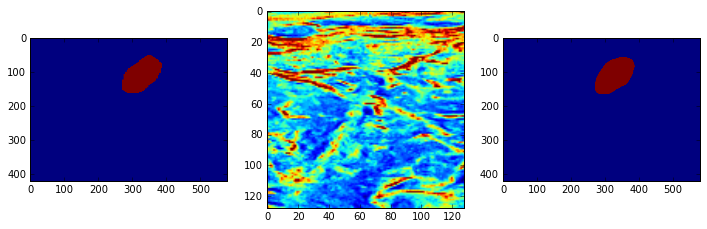

In [62]:
i = np.random.choice(np.flatnonzero(with_masks > 0), 1)
mask = masks[i].squeeze()
img = X[i].squeeze()

new_mask = correct_mask(mask)
pl.figure(figsize=(12, 4))
pl.subplot(131)
pl.imshow(mask)
pl.subplot(132)
pl.imshow(img)
pl.subplot(133)
pl.imshow(new_mask)

In [63]:
new_masks = np.zeros_like(masks)
for i in range(masks.shape[0]):
    if i % 10 == 0:
        print '\r%d / %d' % (i, nlines),
        sys.stdout.flush()
    new_mask = correct_mask(masks[i])
    if np.sum(new_mask > 0) < 2000:
        new_mask[:] = 0
    new_masks[i] = new_mask

5500 / 5508


In [64]:
# binarize
masks = masks > 0
new_masks = new_masks > 0

In [65]:
# compute dice coeff between old and new to find biggest difference
dice_coeffs = []
for i in range(masks.shape[0]):
     dice_coeffs.append(utils.dice_coefficient(masks[i], new_masks[i]))
dice_coeffs = np.array(dice_coeffs, dtype=np.float)

In [66]:
order = np.argsort(dice_coeffs)
print dice_coeffs[order]

[ 0.3565842   0.44726924  0.5614083  ...,  1.          1.          1.        ]


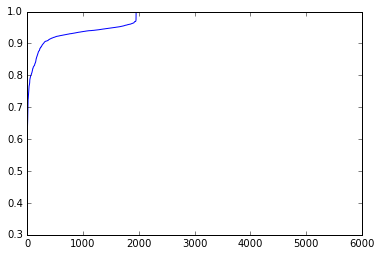

In [67]:
pl.plot(dice_coeffs[order])

4184
4059
1551
4053
2472


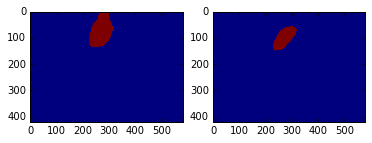

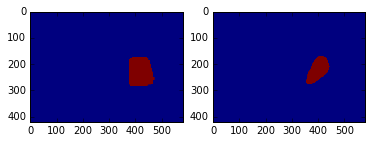

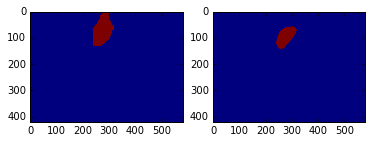

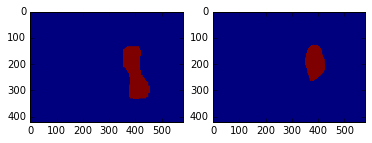

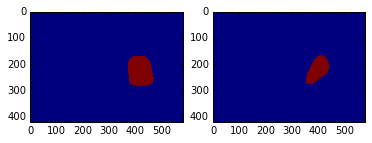

In [68]:
for i in order[5:10]:
    print i
    pl.figure()
    pl.subplot(121)
    pl.imshow(masks[i])
    pl.subplot(122)
    pl.imshow(new_masks[i])

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/transforms.py:2764: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  elif vmax - vmin <= maxabsvalue * tiny:


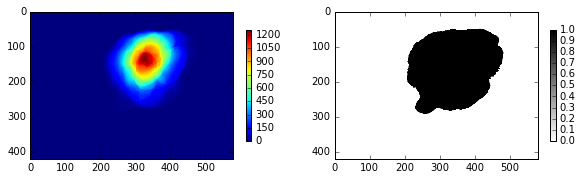

In [69]:
avg_pred = np.sum(new_masks.squeeze(), axis=0)
pl.figure(figsize=(10, 4))
pl.subplot(121)
pl.imshow(avg_pred)
pl.colorbar(shrink=0.5)
pl.subplot(122)
pl.imshow(avg_pred > 3, cmap=cm.binary)
pl.colorbar(shrink=0.5)

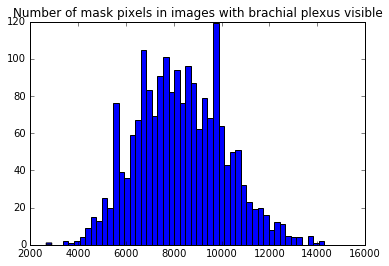

In [70]:
# on pred
nbp_pixels = np.sum(np.sum(new_masks, axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)

In [71]:
# Turn labels into boolean present/missing
pred_binary = np.sum(np.sum(new_masks, axis=2), axis=1) > 0
pred_binary = pred_binary.astype(np.float32)
print "%.2f%% with masks" % (100 * np.count_nonzero(pred_binary) / float(len(pred_binary)))

35.42% with masks


# Save corrected submission

In [72]:
import sys

OUT_SUBMISSION = os.path.splitext(SUBNAME)[0] + '.mask_pca.csv'
assert SUBNAME != OUT_SUBMISSION
print 'Saving to %s' % OUT_SUBMISSION

with open(OUT_SUBMISSION, 'w') as f:
    f.write('img,pixels\n')
    for i in range(new_masks.shape[0]):
        if i % 10 == 0:
            print '\r%d / %d' % (i, new_masks.shape[0]),
            sys.stdout.flush()
            
        runs = runlen_encode(new_masks[i].astype(np.uint8))
        runtext = ' '.join(['%d %d' % rr for rr in runs])
        f.write('%d,%s\n' % (i + 1, runtext))

Saving to ../submissions/submission42.mask_pca.csv
5500 / 5508
